In [1]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import GBTRegressor

from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder
import numpy as np
from pyspark.ml.tuning import CrossValidator

import matplotlib.pyplot as plt

In [2]:
spark_session = SparkSession\
        .builder\
        .appName("Spark Regression")\
        .getOrCreate()

In [3]:
# Load and parse the data file, converting it to a DataFrame.
data = spark_session.read.options(numFeatures=10).format("libsvm").load("data/data_file.txt")
#data = spark_session.read.format("libsvm").load("data/classificationDataLibsvm.txt")

In [4]:
data.show()

+----------+--------------------+
|     label|            features|
+----------+--------------------+
|115.970001|(10,[0,1,2,3,4,5,...|
|    116.32|(10,[0,1,2,3,4,5,...|
|118.690002|(10,[0,1,2,3,4,5,...|
|119.029999|(10,[0,1,2,3,4,5,...|
|114.949997|(10,[0,1,2,3,4,5,...|
|110.440002|(10,[0,1,2,3,4,5,...|
|108.769997|(10,[0,1,2,3,4,5,...|
|108.860001|(10,[0,1,2,3,4,5,...|
|    115.32|(10,[0,1,2,3,4,5,...|
|111.199997|(10,[0,1,2,3,4,5,...|
|116.599998|(10,[0,1,2,3,4,5,...|
|115.050003|(10,[0,1,2,3,4,5,...|
|115.040001|(10,[0,1,2,3,4,5,...|
|    115.75|(10,[0,1,2,3,4,5,...|
|116.870003|(10,[0,1,2,3,4,5,...|
|117.510002|(10,[0,1,2,3,4,5,...|
|115.980003|(10,[0,1,2,3,4,5,...|
|119.019997|(10,[0,1,2,3,4,5,...|
|120.709999|(10,[0,1,2,3,4,5,...|
|121.190002|(10,[0,1,2,3,4,5,...|
+----------+--------------------+
only showing top 20 rows



In [ ]:
# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
#featureIndexer =\
#    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(data)

In [ ]:
# Split the data into training and test sets (30% held out for testing)
#(trainingData, testData) = data.randomSplit([0.7, 0.3]) 
#(trainingData, testData) = l1NormData.randomSplit([0.7, 0.3])
(trainingData, testData) = data.randomSplit([0.7, 0.3])
print(trainingData.select("label").show(10))

In [5]:
# Train model.
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'label')

In [6]:
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [int(x) for x in [10]]) \
    .addGrid(gbt.maxDepth, [int(x) for x in [10]]) \
    .addGrid(gbt.maxBins, [int(x) for x in [32]]) \
    .build()
    #.addGrid(r

In [7]:
crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(),
                          numFolds=3)

In [8]:
# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = data.randomSplit([0.7, 0.3])

In [9]:
cvModel = crossval.fit(trainingData)

In [10]:
predictions = cvModel.transform(testData)

In [11]:
predictions.select("prediction", "label", "features").show(10)

+-------------------+--------+--------------------+
|         prediction|   label|            features|
+-------------------+--------+--------------------+
|0.15054604785012593|0.117746|(10,[0,1,2,3,4,5,...|
|0.15475089283200374|0.118862|(10,[0,1,2,3,4,5,...|
| 0.1659864411909591|0.122768|(10,[0,1,2,3,4,5,...|
| 0.1509911222312215|0.130022|(10,[0,1,2,3,4,5,...|
|0.15054604785012593|0.131138|(10,[0,1,2,3,4,5,...|
|0.15156024795974166|0.131696|(10,[0,1,2,3,4,5,...|
| 0.1509911222312215|0.135045|(10,[0,1,2,3,4,5,...|
|0.15156024795974166|0.136161|(10,[0,1,2,3,4,5,...|
|0.14166798339118508|0.138393|(10,[0,1,2,3,4,5,...|
|0.15156024795974166|0.139509|(10,[0,1,2,3,4,5,...|
+-------------------+--------+--------------------+
only showing top 10 rows



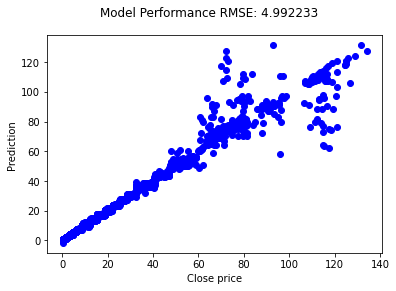

4.992232899512824


In [12]:
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

rmse = evaluator.evaluate(predictions)

rfPred = cvModel.transform(data)

rfResult = rfPred.toPandas()

plt.plot(rfResult.label, rfResult.prediction, 'bo')
plt.xlabel('Close price')
plt.ylabel('Prediction')
plt.suptitle("Model Performance RMSE: %f" % rmse)
plt.show()

print(rmse)

In [13]:
rmse

4.992232899512824

In [14]:
bestModel = cvModel.bestModel

In [15]:
bestModel.getMaxDepth()

10

In [16]:
bestModel.getMaxIter()

10

In [17]:
bestModel.getMaxBins()

32